# Setup

In [1]:
# Setup
import pandas as pd
import numpy as np
import datetime as dt

import glob
import os
import itertools
import collections
import re
import json
import requests
from shutil import copyfile
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline
import colour

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

from shapely.geometry import Polygon, Point
import geopandas as gpd
import pyproj
import folium
from folium import Rectangle
from folium import Polygon as f_Polygon
import affine

from tqdm import tqdm # Progress bar stuff cos progress bars are good
tqdm.pandas() # now can use progress_apply instead of apply

import pickle # Pickle stuff, cos pickling is good

# Styles
pd.set_option('display.float_format', lambda x: '%.2f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.features import geometry_mask

from shapely.ops import transform
from functools import partial
import pyproj

# Charts
def hide_splines(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:,.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,                      # Vertically align label differently for +ve and -ve values
            fontsize=16)                # Set fontsize  

In [2]:
### Utilities
def bng(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in British National Grid
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:27700'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:27700'})
    return df

def wgs(df):
    # Takes dataframe or geodataframe and converts it to a geodataframe with CRS in WGS84
    if type(df) != gpd.GeoDataFrame:
        df = gpd.GeoDataFrame(df, crs={'init':'epsg:4326'})
    elif type(df) == gpd.GeoDataFrame:
        df = df.to_crs(crs={'init':'epsg:4326'})
    return df

# Transform shapely polygons
def poly_to_bng(poly):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:27700'))
    return transform(project, poly)

def poly_to_wgs(poly):
    project = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:27700'),
        pyproj.Proj(init='epsg:4326'))
    return transform(project, poly)

# Mapping outlines
gb_outline = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/gb-outlines_2856975/greatbritain.shp')
england = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/gb-outlines_2856975/england.shp')
wales = gpd.read_file('../../Data/shapefiles/Download_UK+boundaries_1183810/gb-outlines_2856975/wales.shp')
towns = bng(gpd.read_file('../../Data/shapefiles/Major_Towns_and_Cities_December_2015_Boundaries_V2.geojson'))

def plot_uk(df):
    # Check a GeoDataFrame is in the UK somewhere. Expects dataframe in CRS BNG
    check_bng(df)
    fig, ax = plt.subplots(1, figsize=(8, 8))
    gb_outline.plot(ax=ax, color='white', linewidth=0.8, edgecolor='0.6')
    df.plot(ax=ax, linewidth=0.5, color='red', edgecolor='red')

In [3]:
import pysal

/Users/laurence/anaconda3/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## PV Data EDA

In [4]:
df = pd.read_csv('data/fit_repd_pv.csv')

/Users/laurence/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.groupby('source').agg({'postcode': 'count', 'cap': 'sum'})

,postcode,cap
source,,
REPD,771,8159889.00
fitsDB,839694,4965576.27


In [6]:
# add in a type to REPD
df[df['source']=='REPD'] = df[df['source']=='REPD'].fillna(value={'type': 'repd'}).copy()

In [7]:
df.groupby(['source', 'type']).agg({'source': 'count', 'cap': 'sum'}) #.plot(kind='bar')

source        cap
source type                                        
REPD   repd                         1083 8159889.00
fitsDB Community                    3038  270053.93
       Domestic                   807081 2831636.56
       Non Domestic (Commercial)   27823 1578374.13
       Non Domestic (Industrial)    1752  285511.65

In [8]:
df.groupby('source').cap.sum()

source
REPD     8159889.00
fitsDB   4965576.27
Name: cap, dtype: float64

In [9]:
df.groupby(['source', 'type']).agg({'postcode': 'count', 'cap': 'sum'}).cap.sum()

13125465.269995676

In [10]:
df.groupby(['source', 'type']).agg({'cap': 'sum'})\
  .transform(lambda x: x/1000000)\
  .reset_index()\
  .replace({'type': 'repd'}, 'Commercial & Industrial')\
  .replace({'type': 'Non Domestic (Commercial)'}, 'Commercial & Industrial')\
  .replace({'type': 'Non Domestic (Industrial)'}, 'Commercial & Industrial')\
  .groupby(['source', 'type']).agg({'cap': 'sum'})\
  .reset_index()\
#   .sort_index(ascending=False)

,source,type,cap
0,REPD,Commercial & Industrial,8.16
1,fitsDB,Commercial & Industrial,1.86
2,fitsDB,Community,0.27
3,fitsDB,Domestic,2.83


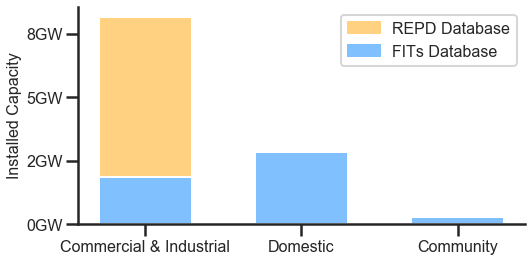

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
grouped=\
    df.groupby(['source', 'type']).agg({'cap': 'sum'})\
      .transform(lambda x: x/1000000)\
      .reset_index()\
      .replace({'type': 'repd'}, 'Commercial & Industrial')\
      .replace({'type': 'Non Domestic (Commercial)'}, 'Commercial & Industrial')\
      .replace({'type': 'Non Domestic (Industrial)'}, 'Commercial & Industrial')\
      .groupby(['source', 'type']).agg({'cap': 'sum'})\
      .reset_index()\
      .sort_values('cap', ascending=False)


import matplotlib.patches as mpatches

# https://www.sessions.edu/color-calculator/
col1 = '#ffd181' # orange
col2 = '#81c0ff' # blue
col3 = '#ff9281' # red
colors = [col1, col2, col2, col2]

repd = mpatches.Patch(color=col1, label='REPD Database')
fits = mpatches.Patch(color=col2, label='FITs Database')
plt.legend(handles=[repd, fits], fontsize=16)

ax.bar(x=grouped.type, height=grouped.cap, color=colors, width=0.6, bottom=None, align='center', data=None)

ax.get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}GW'))
labels = ['Commercial & Industrial', 'Domestic', 'Community']
plt.xticks(ticks=plt.xticks()[0], labels=labels, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Installed Capacity', fontsize=16)

hide_splines(ax)
# plt.savefig('img/chart_pv_databases.png', bounding_box='tight', dpi=200)

In [12]:
grouped[grouped.source=='fitsDB'].type.values

array(['Domestic', 'Commercial & Industrial', 'Community'], dtype=object)

In [13]:
df.groupby(['source', 'type']).agg({'cap': 'count'})\
  .reset_index()\
  .replace({'type': 'repd'}, 'Commercial & Industrial')\
  .replace({'type': 'Non Domestic (Commercial)'}, 'Commercial & Industrial')\
  .replace({'type': 'Non Domestic (Industrial)'}, 'Commercial & Industrial')\
  .groupby(['source', 'type']).agg({'cap': 'sum'})\
  .reset_index()

,source,type,cap
0,REPD,Commercial & Industrial,1083
1,fitsDB,Commercial & Industrial,29575
2,fitsDB,Community,3038
3,fitsDB,Domestic,807081


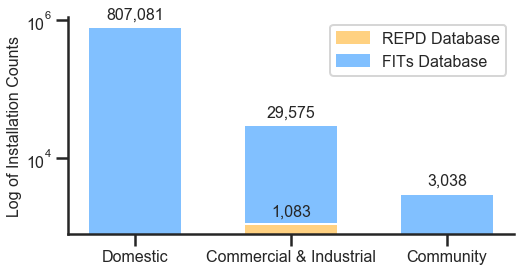

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
grouped=\
    df.groupby(['source', 'type']).agg({'cap': 'count'})\
      .reset_index()\
      .replace({'type': 'repd'}, 'Commercial & Industrial')\
      .replace({'type': 'Non Domestic (Commercial)'}, 'Commercial & Industrial')\
      .replace({'type': 'Non Domestic (Industrial)'}, 'Commercial & Industrial')\
      .groupby(['source', 'type']).agg({'cap': 'sum'})\
      .reset_index()\
      .sort_values('cap', ascending=False)

fits = mpatches.Patch(color=col1)
repd = mpatches.Patch(color=col2)
plt.legend(handles=[fits, repd], labels=['REPD Database', 'FITs Database'], fontsize=16)

colors = [col2, col2, col2, col1]
ax.bar(x=grouped.type, height=grouped.cap, color=colors, width=0.6, bottom=None, align='center', data=None)

ax.get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
labels = ['Domestic', 'Commercial & Industrial', 'Community']
plt.xticks(ticks=plt.xticks()[0], labels=labels, rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Log of Installation Counts', fontsize=16)
ax.set_yscale('log')
# ax.set_ylim([1, 10000000])

hide_splines(ax)

# Call the function above. All the magic happens there.
add_value_labels(ax)

# plt.savefig('img/chart_pv_databases_count.png', bounding_box='tight', dpi=200)

## Chloropleth

## More stats

In [15]:
1 - len(df[df.cap>4]) / len(df)

0.9352087414379794

In [16]:
len(df)

840777

## Domestic only

In [17]:
# domestic only
dom = df[df['type'] == 'Domestic']

In [18]:
dom.lsoa.value_counts().head(1)

Unknown    80382
Name: lsoa, dtype: int64

80382 unknown LSOA values in FiT Domestic database.

In [19]:
dom[dom.lsoa=='Unknown'].cap.sum() / dom.cap.sum()

0.0898825059667968

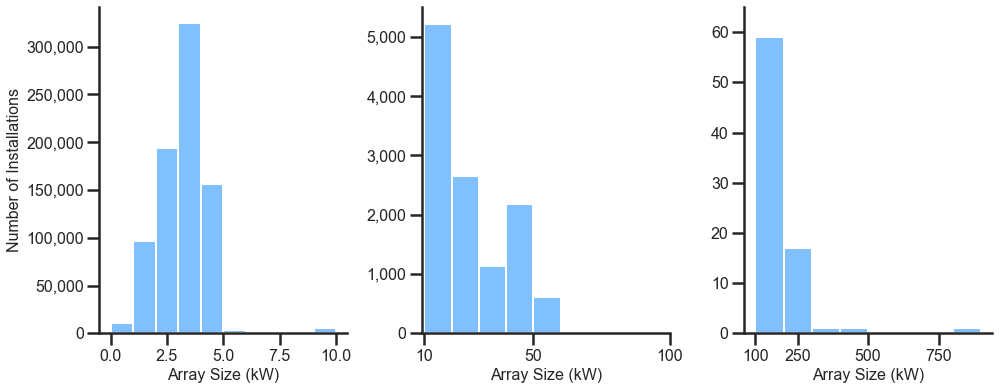

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

bins1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dom.hist(column='cap', bins=bins1, ax=axes[0], color=col2)

bins2 = range(10, 100, 10)
dom.hist(column='cap', bins=bins2, ax=axes[1], color=col2)
axes[1].set_xlim(left=9, right=None)
axes[1].set_ylim(0, 5500)
axes[2].set_ylim(0, 65)
axes[1].set_xticks([10, 50, 100])
axes[0].set_ylabel('Number of Installations', fontsize=16)
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)

bins3 = range(100, 1000, 100)
dom.hist(column='cap', bins=bins3, ax=axes[2], color=col2)
axes[2].set_xticks([100, 250, 500, 750])

for ax in axes:
    ax.set_title(None)
    ax.grid(None)
    ax.get_yaxis().set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    ax.tick_params(axis='x', rotation=0, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlabel('Array Size (kW)', fontsize=16)
    hide_splines(ax)
# plt.savefig('img/chart_domestic_hist.png', bounding_box='tight', dpi=200)

#### Filter to less than 10kW

In [21]:
dom[dom.cap<10].cap.sum() / dom.cap.sum()

0.8840462986535247

In [22]:
dom[dom.cap<10].cap.count() / dom.cap.count()

0.9852208142677129

In [23]:
dom = dom[dom.cap<10]

### Group by country and select England

In [24]:
dom.groupby('country').sum()

,cap,id,x,y
country,,,,
England,2159812.23,0.00,0.00,0.00
Scotland,182079.68,0.00,0.00,0.00
Unknown,756.15,0.00,0.00,0.00
Wales,160649.76,0.00,0.00,0.00


In [25]:
dom[dom.country=='England'].cap.sum()/dom.cap.sum()

0.8627867658191783

In [26]:
dom[dom.country=='England'].cap.count()/dom.cap.count()

0.8651416771363498

# Spatial Autocorrelation of Domestic PV

Could assign LSOA based on intersection with postcode district.  
But I have 90% of Domestic PV in LSOAs anyway.  
LSOAs try to be equal population so would have to consider that.  


#### Tidy up

In [27]:
## Do Moran's I here before adding (and dropping out lots of regions)

## Add in everything else

In [28]:
dom_lsoa = dom[dom['lsoa']!='Unknown'].copy()

In [29]:
# Group by LSOA
pv_lsoa = dom_lsoa.groupby('lsoa').sum().reset_index()[['lsoa', 'cap']]

In [30]:
pv_lsoa.head(1)

,lsoa,cap
0,E01000002,22.68


In [31]:
# LSOA shapefiles and ID
lsoa = gpd.read_file('../../../Dropbox/ESDA/Spatial/Coursework/data/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales/Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp')

In [32]:
lsoa = lsoa[['lsoa11cd', 'lsoa11nm', 'geometry']]
lsoa.columns = ['lsoa', 'lsoa11nm', 'geometry']

In [33]:
lsoa.head(1)

,lsoa,lsoa11nm,geometry
0,E01000001,City of London 001A,"POLYGON ((532105.0920000002 182011.2300000004,..."


In [34]:
# House prices
# https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbylowerlayersuperoutputareahpssadataset46
house_prices = pd.read_excel('data/hpssadataset46medianpricepaidforresidentialpropertiesbylsoa.xls', sheet_name='Data', skiprows=5)

# Take average median house prices from 2009 to 2018 inclusive
# Replace : which is missing value, with NaN so mean works properly
house_prices['price'] = house_prices.iloc[:,57:97].replace(':', np.nan).mean(axis=1)
house_prices = house_prices[['LSOA code', 'price']]
house_prices.columns = ['lsoa', 'price']

In [35]:
house_prices.head(1)

,lsoa,price
0,E01011950,40020.62


(0, 1000000)

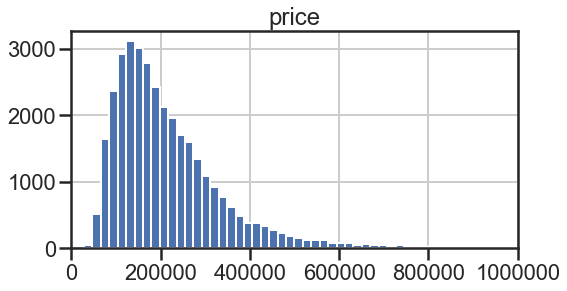

In [36]:
fig, ax = plt.subplots(figsize=(8,4))
house_prices.hist(column='price', bins=200, ax=ax)
ax.set_xlim(0, 1000000)

In [37]:
# Property age at LSOA
property_age = pd.read_csv('../../../Dropbox/ESDA/Spatial/Coursework/data/voapropertyage.csv')
# property_age.head(1)
property_age = property_age[['AREA_CODE', 'MODE1_TYPE', 'MODE1_PC', 'MODE2_TYPE', 'MODE2_PC', 'MODE2_MODE1_RATIO']]
property_age.columns = ['lsoa', 'MODE1_TYPE', 'MODE1_PC', 'MODE2_TYPE', 'MODE2_PC', 'MODE2_MODE1_RATIO']
age_encode =  {'BP_PRE_1900': 1, 'BP_1900_1918': 2, 'BP_1919_1929': 3, 'BP_1930_1939': 4, 'BP_1945_1954': 5, 'BP_1955_1964': 6, 'BP_1965_1972': 7, 'BP_1973_1982': 8, 'BP_1983_1992': 9, 'BP_1993_1999': 10, 'BP_2000_2009': 11, 'BP_2010_2015': 12, 'BP_UNKNOWN': 13}
property_age['MODE1_TYPE'].replace(age_encode, inplace=True)
property_age['MODE2_TYPE'].replace(age_encode, inplace=True)
property_age.head(1)

,lsoa,MODE1_TYPE,MODE1_PC,MODE2_TYPE,MODE2_PC,MODE2_MODE1_RATIO
0,E01031349,4,0.73,5,0.25,0.34


In [38]:
# epc = pd.read_csv('../../../Dropbox/ESDA/Spatial/Coursework/data/EPC.csv') # large csv - 173mb file, 1.388m rows
# epc['postcode_outward'] = [x[0] for x in epc['postcode'].str.split(' ')]
# epc['postcode_inward'] = [x[1] for x in epc['postcode'].str.split(' ')]

In [39]:
# epc.head(1)

In [40]:
# Deprivation indices
# http://opendatacommunities.org/data/societal-wellbeing/imd/indices
deprivation = pd.read_csv('data/Deprivation.csv')

In [41]:
# just get index of multiple deprivation and take decile rather than score or rank
dep = deprivation[(deprivation['Indices of Deprivation'] == 'a. Index of Multiple Deprivation (IMD)') & (deprivation['Measurement']=='Decile ')]

In [42]:
dep = dep[['FeatureCode', 'Value']]
dep.columns = ['lsoa', 'dep_decile']

In [43]:
dep.head(1)

,lsoa,dep_decile
817998,E01008649,3.00


## Join up LSOA geometry, Property Age, Price & Deprivation

In [44]:
merge = pd.merge(lsoa, pv_lsoa, on='lsoa', sort=False)
merge = pd.merge(merge, property_age, on='lsoa')
merge = pd.merge(merge, house_prices, on='lsoa')
merge = pd.merge(merge, dep, on='lsoa')

In [45]:
df = merge.copy()

In [46]:
df.head(1)

,lsoa,lsoa11nm,geometry,cap,MODE1_TYPE,MODE1_PC,MODE2_TYPE,MODE2_PC,MODE2_MODE1_RATIO,price,dep_decile
0,E01000002,City of London 001B,"POLYGON ((532746.8130000001 181786.8910000008,...",22.68,7,0.76,12,0.17,0.22,676346.84,9.00


In [47]:
# Check what we've got
# df.plot(lw=0.1)

# Spatial Regression
https://www.earthdatascience.org/tutorials/intro-to-spatial-regression/

and 

http://pysal.org/notebooks/explore/esda/Spatial_Autocorrelation_for_Areal_Unit_Data.html

In [48]:
import pysal

from pysal.model.spreg import ols
from pysal.model.spreg import ml_error
from pysal.model.spreg import ml_lag

## Spatial Regression with My Data

In [49]:
df_back = df.copy()

In [50]:
# 13 here is unknown, so lets get rid of it
df = df[df.MODE1_TYPE != 13]
# and drop missing values
df = df.dropna()

In [51]:
# Deal with outliers
df.sort_values('cap', ascending=False)[:1]

,lsoa,lsoa11nm,geometry,cap,MODE1_TYPE,MODE1_PC,MODE2_TYPE,MODE2_PC,MODE2_MODE1_RATIO,price,dep_decile
4265,E01005081,Manchester 039C,"POLYGON ((383233.6579999998 393096.5189999994,...",872.91,8,0.62,3,0.34,0.54,150917.50,1.00


In [52]:
# Deal with outliers
# df.sort_values('cap', ascending=False)[:20].loc[15996].geometry

In [53]:
# df.sort_values('cap', ascending=False)[:20].loc[19176].geometry

I want to work with my dataframe `df`.  
My y dependent variable is the solar capacity `cap`.  
My x independent variables are `MODE1_TYPE` which are decades ish of mean house age, smaller number is older house, 1 is pre-1900.  
`price` is median house price, `dep_decile` is the decile of an aggregated deprivation index.

## Electricity consumption by LSOA

In [54]:
elec = pd.read_csv('data/LSOA_domestic_electricity_2017.csv', skiprows=1)

In [55]:
elec = elec[['Local Authority Name', 'Local Authority Code',
           'Middle Layer Super Output Area (MSOA) Name',
           'Middle Layer Super Output Area (MSOA) Code',
           'Lower Layer Super Output Area (LSOA) Name',
           'Lower Layer Super Output Area (LSOA) Code',
           'Median domestic electricity consumption \n(kWh per meter)']]

In [56]:
df['lsoa'] = df['lsoa'].str.strip()
elec['Lower Layer Super Output Area (LSOA) Code'] = elec['Lower Layer Super Output Area (LSOA) Code'].str.strip()

In [57]:
# Merge in (includes handy MSOA codes!)
df = pd.merge(df, elec, left_on='lsoa', right_on='Lower Layer Super Output Area (LSOA) Code')

### Add employment

In [58]:
employment = pd.read_csv('data/economic activity by LSOA 2011.csv', skiprows=8)

employment['employed_ratio'] = pd.to_numeric(employment['Economically active: Total'], errors='coerce') / pd.to_numeric(employment['All categories: Economic activity'], errors='coerce')

employment = employment.dropna()

employment['lsoa'] = [x[0].strip() for x in employment['2011 super output area - lower layer'].str.split(':')]

In [59]:
df = pd.merge(df, employment, left_on='lsoa', right_on='lsoa')

## Add rural / urban at LSOA

In [60]:
urb = pd.read_csv('data/Rural_Urban_Classification_2011_of_Lower_Layer_Super_Output_Areas_in_England_and_Wales.csv')

urb.RUC11CD = pd.Categorical(urb.RUC11CD)
urb['rural'] = urb.RUC11CD.cat.codes
urb = urb[['LSOA11CD', 'rural']]

In [61]:
df = pd.merge(df, urb, left_on='lsoa', right_on='LSOA11CD')

## Add dwelling type

In [179]:
dwelling= pd.read_csv('data/lsoa_percent_detached_homes_2011.csv', skiprows=8)

dwelling = dwelling.dropna().copy()

lsoas = [x[0].strip() for x in dwelling['2011 super output area - lower layer'].str.split(':')]

dwelling['lsoa'] = lsoas
dwelling['detach'] = dwelling['2011']
dwelling['detach'] = pd.to_numeric(dwelling['detach'])

In [180]:
df = pd.merge(df, dwelling[['lsoa', 'detach']], left_on='lsoa', right_on='lsoa')

### Add tenure

In [166]:
owned = pd.read_csv('data/lsoa_rented_owned_housing_2011.csv', skiprows=8)
owned = owned.dropna()

In [167]:
lsoas = [x[0].strip() for x in owned['2011 super output area - lower layer'].str.split(':')]
owned['lsoa'] = lsoas
owned['own'] = owned['%.1']

In [169]:
df = pd.merge(df, owned[['lsoa', 'own']], left_on='lsoa', right_on='lsoa')

### Tidy

In [171]:
df['elec'] = df['Median domestic electricity consumption \n(kWh per meter)'].str.strip(',')
df['elec'] = df['elec'].str.replace(',', '')
df['elec'] = df['elec'].str.strip()
df['elec'] = pd.to_numeric(df['elec'])

## Merge to MSOA if desired...

In [183]:
msoa = df.dissolve('Middle Layer Super Output Area (MSOA) Code', 
                   aggfunc={'cap': 'sum', 'MODE1_TYPE': 'mean', 'price': 'mean', 
                            'dep_decile': 'mean', 'elec': 'mean', 'employed_ratio': 'mean',
                            'rural': 'mean', 'detach': 'mean', 'own': 'mean'
                            })

In [184]:
msoa.columns

Index(['geometry', 'cap', 'MODE1_TYPE', 'price', 'dep_decile', 'elec',
       'employed_ratio', 'rural', 'detach', 'own'],
      dtype='object')

## Add in x and y

In [185]:
df['x'] = df.geometry.centroid.x
df['y'] = df.geometry.centroid.y
msoa['x'] = msoa.geometry.centroid.x
msoa['y'] = msoa.geometry.centroid.y

## Normalise

In [186]:
# Normalise all data first 
# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
from sklearn import preprocessing

def normalise_df(x):
    arr = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled = min_max_scaler.fit_transform(arr)
    df_normalised = pd.DataFrame(scaled)
    return df_normalised

In [187]:
cols = ['cap', 'MODE1_TYPE', 'price', 'dep_decile', 'elec', 'employed_ratio', 'rural', 'detach', 'own', 'x', 'y']

df_norm = df[cols]
df_norm = normalise_df(df_norm)
msoa_norm = msoa[cols]
msoa_norm = normalise_df(msoa_norm)

In [188]:
df_norm = gpd.GeoDataFrame(df_norm, geometry=df.reset_index().geometry)
msoa_norm = gpd.GeoDataFrame(msoa_norm, geometry=msoa.reset_index().geometry)

In [189]:
cols = ['cap', 'hage', 'hprice', 'dep', 'elec', 'empl', 'rural', 'detach', 'own', 'x', 'y', 'geometry']
df_norm.columns = cols
msoa_norm.columns = cols

## Save and run Regression

In [190]:
# Let's create a format that pysal is happy with. Exporting from geopandas as a shapefile will create a .dbf file too. 
# df.to_file('data/spatial_analysis_dataframe_20190818.shp')
df_norm.to_file('data/spatial_analysis_dataframe_norm_20190821.shp')
msoa_norm.to_file('data/spatial_analysis_MSOA_norm_20190821.shp')

/Users/laurence/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### Regression with LSOA

In [230]:
# f = pysal.lib.io.open("data/spatial_analysis_dataframe_20190818.dbf",'r')
f = pysal.lib.io.open("data/spatial_analysis_dataframe_norm_20190821.dbf",'r')

y = np.array(f.by_col['cap'])
y.shape = (len(y),1)
X= []
X.append(f.by_col['hage'])
X.append(f.by_col['hprice'])
X.append(f.by_col['dep'])
X.append(f.by_col['elec'])
X.append(f.by_col['empl'])
X.append(f.by_col['rural'])
X.append(f.by_col['detach'])
X.append(f.by_col['own'])
# X.append(f.by_col['x'])
# X.append(f.by_col['y'])
X = np.array(X).T

In [233]:
ls = ols.OLS(y, X, name_y = 'solar', 
             name_x = ['House Age', 'House Price', 'Deprivation', 'Elec', 'Employed', 'rural', 'detach', 'own'], 
             name_ds = 'Domestic PV Distribution')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Domestic PV Distribution
Weights matrix      :        None
Dependent Variable  :       solar                Number of Observations:       30742
Mean dependent var  :      0.0761                Number of Variables   :           9
S.D. dependent var  :      0.0756                Degrees of Freedom    :       30733
R-squared           :      0.3740
Adjusted R-squared  :      0.3738
Sum squared residual:     109.874                F-statistic           :   2294.6957
Sigma-square        :       0.004                Prob(F-statistic)     :           0
S.E. of regression  :       0.060                Log likelihood        :   42979.949
Sigma-square ML     :       0.004                Akaike info criterion :  -85941.898
S.E of regression ML:      0.0598                Schwarz criterion     :  -85866.898

-----------------------------------------------------------------

### Regression with MSOA

In [234]:
f = pysal.lib.io.open("data/spatial_analysis_MSOA_norm_20190821.dbf",'r')
y = np.array(f.by_col['cap'])
y.shape = (len(y),1)
X= []
X.append(f.by_col['hage'])
X.append(f.by_col['hprice'])
X.append(f.by_col['dep'])
X.append(f.by_col['elec'])
X.append(f.by_col['empl'])
X.append(f.by_col['rural'])
X.append(f.by_col['detach'])
X.append(f.by_col['own'])
X = np.array(X).T
ls_msoa = ols.OLS(y, X, name_y = 'solar', 
             name_x = ['House Age', 'House Price', 'Deprivation', 'Elec', 'Employed', 'rural', 'detach', 'own'], 
             name_ds = 'Domestic PV Distribution')
print(ls_msoa.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Domestic PV Distribution
Weights matrix      :        None
Dependent Variable  :       solar                Number of Observations:        6764
Mean dependent var  :      0.0892                Number of Variables   :           9
S.D. dependent var  :      0.0768                Degrees of Freedom    :        6755
R-squared           :      0.4609
Adjusted R-squared  :      0.4602
Sum squared residual:      21.511                F-statistic           :    721.8484
Sigma-square        :       0.003                Prob(F-statistic)     :           0
S.E. of regression  :       0.056                Log likelihood        :    9851.488
Sigma-square ML     :       0.003                Akaike info criterion :  -19684.976
S.E of regression ML:      0.0564                Schwarz criterion     :  -19623.601

-----------------------------------------------------------------

### Spatial Analysis 

In [215]:
w = pysal.lib.weights.Queen.from_shapefile('data/spatial_analysis_dataframe_norm_20190821.shp')
w2 = pysal.lib.weights.Queen.from_shapefile('data/spatial_analysis_MSOA_norm_20190821.shp')

/Users/laurence/anaconda3/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 14 disconnected observations 
  Island ids: 1621, 3354, 3413, 3573, 3574, 3576, 3589, 4802, 9701, 14785, 17655, 18492, 19103, 19122
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
/Users/laurence/anaconda3/lib/python3.7/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 8 disconnected observations 
  Island ids: 777, 829, 832, 835, 1137, 4446, 6090, 6627
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


OLS regression assumes that each observation is independent from all others. However, in practice, locations that are near eachother are not likely to be independent.

We can evaluate spatial autocorrelation in the residuals with Moran’s I test. Our first step in that process is to create a spatial weights matrix. PySAL’s example data has a GAL file that we can read in directly to create this matrix.

We can pass this weights matrix to the pysal.Moran function, along with our model residuals (ls.u).

The observed value for I is much higher than the value we would expect if there was no spatial dependence. The p-value is the probability that we would observe the value of I that we did (or one greater) if there were no spatial dependence.

## Morans at LSOA level

http://pysal.org/notebooks/viz/splot/esda_morans_viz

In [203]:
mi = pysal.explore.esda.Moran(ls.u, w, two_tailed=False, )
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

('WARNING: ', 1621, ' is an island (no neighbors)')
('WARNING: ', 3354, ' is an island (no neighbors)')
('WARNING: ', 3413, ' is an island (no neighbors)')
('WARNING: ', 3573, ' is an island (no neighbors)')
('WARNING: ', 3574, ' is an island (no neighbors)')
('WARNING: ', 3576, ' is an island (no neighbors)')
('WARNING: ', 3589, ' is an island (no neighbors)')
('WARNING: ', 4802, ' is an island (no neighbors)')
('WARNING: ', 9701, ' is an island (no neighbors)')
('WARNING: ', 14785, ' is an island (no neighbors)')
('WARNING: ', 17655, ' is an island (no neighbors)')
('WARNING: ', 18492, ' is an island (no neighbors)')
('WARNING: ', 19103, ' is an island (no neighbors)')
('WARNING: ', 19122, ' is an island (no neighbors)')
Observed I: 0.4013957253873726 
Expected I: -3.2529846133827784e-05 
   p-value: 0.0


15 islands with no neighbours

Moran's I was observed as 0.40, and expected from a reference distribution as -3.25.
Spatial autoregression

We can use a spatial regression model to account for spatial non-independence.   
The spreg module has several different functions for creating a spatial regression model.  
In this example, we will use a spatial error model, but the implementation of a spatial lag model is similar.

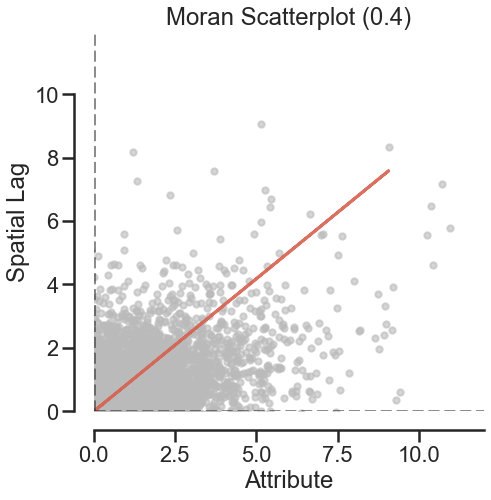

In [204]:
from pysal.viz.splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(mi, zstandard=True)
ax.set_xlim([0, 12])
ax.set_ylim([0, 12])
plt.show()

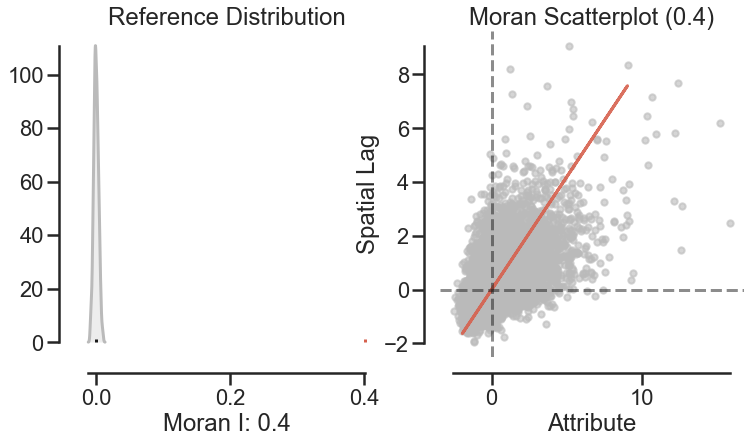

In [220]:
from pysal.viz.splot.esda import plot_moran

plot_moran(mi, zstandard=True, figsize=(12,6))
# plt.savefig('img/morans_plot_and_ref.png', bounding_box='tight', dpi=150)

In [206]:
mi.p_sim

0.001

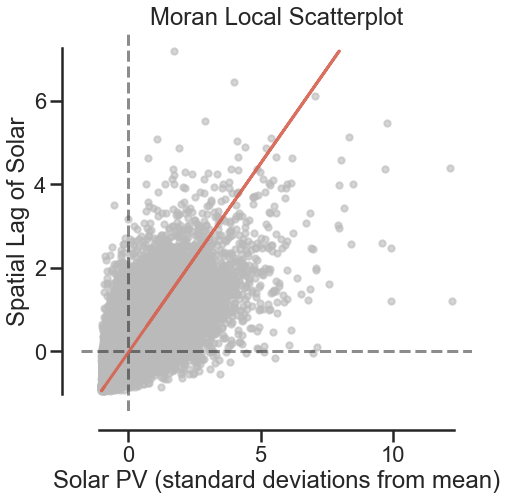

In [212]:
# local moran
# http://pysal.org/notebooks/viz/splot/esda_morans_viz
from pysal.viz.splot.esda import moran_scatterplot
from pysal.explore.esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Solar PV (standard deviations from mean)')
ax.set_ylabel('Spatial Lag of Solar')
plt.savefig('img/moran_local_scatter.png', bounding_box='tight', dpi=150)

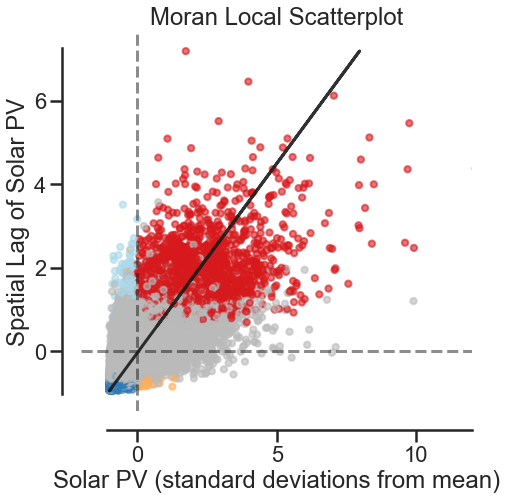

In [228]:
fig, ax = moran_scatterplot(moran_loc, p=0.01)
ax.set_xlabel('Solar PV (standard deviations from mean)')
ax.set_ylabel('Spatial Lag of Solar PV')
ax.set_xlim([-2, 12])

# We can distinguish the specific type of local spatial autocorrelation 
# in High-High, Low-Low, High-Low, Low-High. 
# Where the upper right quadrant displays HH, 
# the lower left, LL, the upper left LH and the lower left HL.

plt.savefig('img/moran_local_scatter_high_low.png', bbox_inches = 'tight', pad_inches=1, dpi=150)

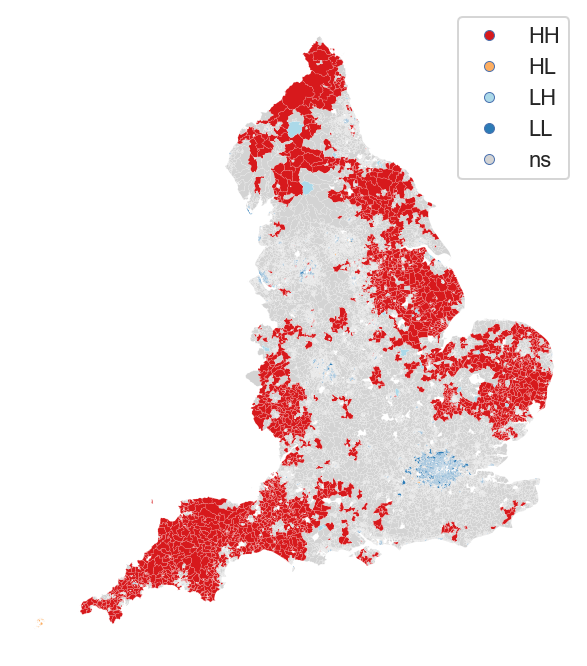

In [229]:
from pysal.viz.splot.esda import lisa_cluster

# fig, ax = plt.subplots()
# england_outline.plot(ax=ax)
# wales_outline.plot(ax=ax)
# england_outline.plot()
lisa_cluster(moran_loc, df, p=0.01, figsize = (12,12))
plt.savefig('img/moran_hot_coldspots_UK.png', bbox_inches = 'tight', pad_inches=1, dpi=150)

## Regression using weights matrix

In [243]:
np.log(10)

2.302585092994046

In [270]:
def add_50(x):
    return [x + 50 for x in x]

## Tried to address heteroscedasticity by transforming by log

In [268]:
# f = pysal.lib.io.open("data/spatial_analysis_dataframe_20190818.dbf",'r')
f = pysal.lib.io.open("data/spatial_analysis_dataframe_norm_20190821.dbf",'r')

y = np.array(np.log(add_50(f.by_col['cap'])))
y.shape = (len(y),1)
X= []
X.append(np.log(add_50(f.by_col['hage'])))
X.append(np.log(add_50(f.by_col['hprice'])))
X.append(np.log(add_50(f.by_col['dep'])))
X.append(np.log(add_50(f.by_col['elec'])))
X.append(np.log(add_50(f.by_col['empl'])))
X.append(np.log(add_50(f.by_col['rural'])))
X.append(np.log(add_50(f.by_col['detach'])))
X.append(np.log(add_50(f.by_col['own'])))
# X.append(f.by_col['x'])
# X.append(f.by_col['y'])
X = np.array(X).T

In [269]:
ls = ols.OLS(y, X, name_y = 'solar', 
             w=w, spat_diag=True,
             name_x = ['House Age', 'House Price', 'Deprivation', 'Elec', 'Employed', 'rural', 'detach', 'own'], 
             name_ds = 'Domestic PV Distribution')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Domestic PV Distribution
Weights matrix      :     unknown
Dependent Variable  :       solar                Number of Observations:       30742
Mean dependent var  :      3.9135                Number of Variables   :           9
S.D. dependent var  :      0.0015                Degrees of Freedom    :       30733
R-squared           :      0.3745
Adjusted R-squared  :      0.3744
Sum squared residual:       0.044                F-statistic           :   2300.4441
Sigma-square        :       0.000                Prob(F-statistic)     :           0
S.E. of regression  :       0.001                Log likelihood        :  163357.447
Sigma-square ML     :       0.000                Akaike info criterion : -326696.893
S.E of regression ML:      0.0012                Schwarz criterion     : -326621.893

-----------------------------------------------------------------

## Spatial lagged regression

In [282]:
## create small test sample
df_norm[:1000].to_file('data/spatial_analysis_dataframe_LSOA_TEST.shp')

In [283]:
w_test = pysal.lib.weights.Queen.from_shapefile('data/spatial_analysis_dataframe_LSOA_TEST.shp')
f_test = pysal.lib.io.open("data/spatial_analysis_dataframe_LSOA_TEST.dbf",'r')

In [285]:
y = np.array(f_test.by_col['cap'])
y.shape = (len(y),1)
X= []
X.append(f_test.by_col['hage'])
X.append(f_test.by_col['hprice'])
X.append(f_test.by_col['dep'])
X.append(f_test.by_col['elec'])
X.append(f_test.by_col['empl'])
X.append(f_test.by_col['rural'])
X.append(f_test.by_col['detach'])
X.append(f_test.by_col['own'])
X = np.array(X).T
ls_test = ols.OLS(y, X, name_y = 'solar',
             w=w_test, spat_diag=True,
             name_x = ['House Age', 'House Price', 'Deprivation', 'Elec', 'Employed', 'rural', 'detach', 'own'], 
             name_ds = 'Domestic PV Distribution')
print(ls_test.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :Domestic PV Distribution
Weights matrix      :     unknown
Dependent Variable  :       solar                Number of Observations:        1000
Mean dependent var  :      0.0180                Number of Variables   :           9
S.D. dependent var  :      0.0152                Degrees of Freedom    :         991
R-squared           :      0.3564
Adjusted R-squared  :      0.3512
Sum squared residual:       0.149                F-statistic           :     68.6018
Sigma-square        :       0.000                Prob(F-statistic)     :    1.37e-89
S.E. of regression  :       0.012                Log likelihood        :    2987.242
Sigma-square ML     :       0.000                Akaike info criterion :   -5956.484
S.E of regression ML:      0.0122                Schwarz criterion     :   -5912.314

-----------------------------------------------------------------

In [288]:
ml_lag = ml_lag.ML_Lag(y, X, name_y = 'solar', 
             w=w_test, spat_diag=True,
             name_x = ['House Age', 'House Price', 'Deprivation', 'Elec', 'Employed', 'rural', 'detach', 'own'])
print(ml_lag.summary)

TypeError: No loop matching the specified signature and casting
was found for ufunc add

In [290]:
np.__version__

'1.16.4'

In [ ]:
from sklearn.metrics import mean_squared_error as mse

#                      'OLS+W': mse(y, m2.predy.flatten()), \
mses = pd.Series({'OLS': mse(y, ls.predy.flatten()), \
                     'Lag': ml_lag(y, m3.predy_e)
                    })
mses.sort_values()